In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import math
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

import statsmodels.api as sm


#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Notebook Directory Set: /shared_folder/eas_508_project/notebooks
Current working directory: /shared_folder/eas_508_project


In [3]:
pbp_path = 'data/interim/pbp/'

pbp_name = 'featured_11_11.csv'

df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})
shape = df.shape
columns = df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

df.head()

/tmp/ipykernel_57560/1051494428.py:5: DtypeWarning: Columns (84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})


✔✔✔ File Loaded

Shape: (307576, 106)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'yrdln', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'run_location', 'run_gap', 'score_differential', 'no_score_prob', 'fg_prob', 'td_prob', 'ep', 'epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'penalty', 'field_goal_attempt', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 'season', 'order_sequence', 'stadium', 'weather', 'nfl_api_id', 'fixed_drive'

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense,home_team,...,bigs,personnel_num,ydstosuccess,previous_success,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa
0,2016_01_BUF_BAL,58,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1,12,5.0,0.0,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042
1,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1,12,2.8,1.0,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173
2,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1,12,5.0,1.0,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173
3,2016_01_BUF_BAL,130,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1,12,7.0,0.0,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042
4,2016_01_BUF_BAL,154,BAL,UNDER_CENTER,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,2,21,1.0,1.0,0.420136,0.420369,0.006901,0.429168,0.429205,0.010042


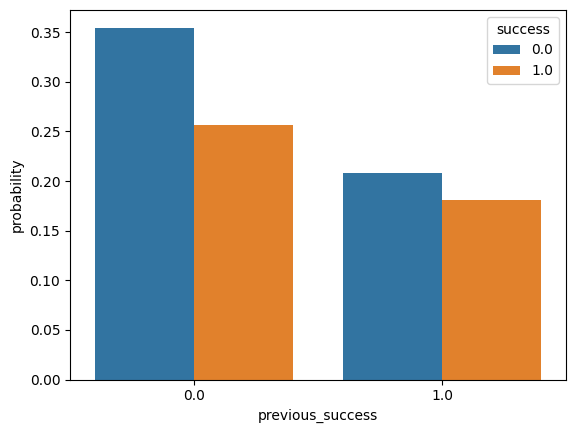

In [4]:
sns.countplot(data=df, x='previous_success', hue='success', stat='probability')
plt.show()

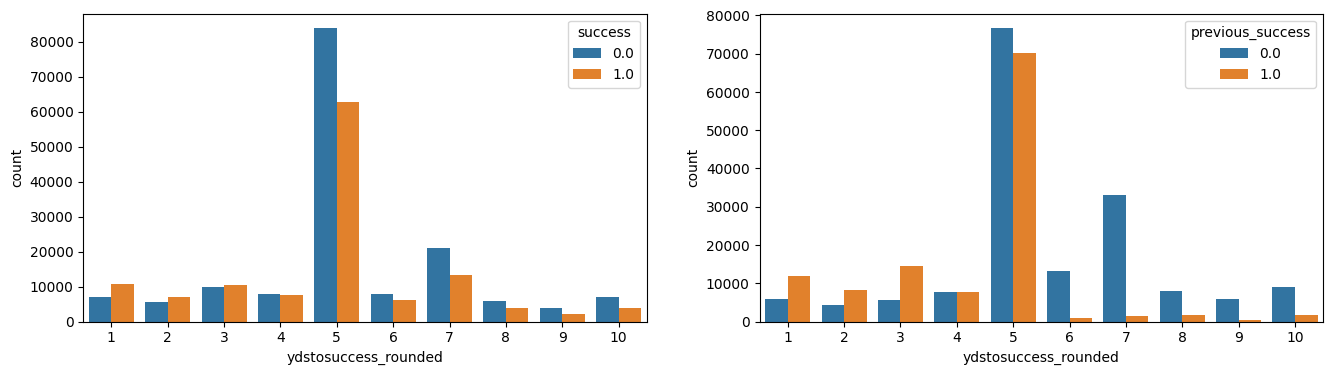

In [5]:
df['ydstosuccess_rounded'] = df['ydstosuccess'].apply(lambda x: math.ceil(x))

fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.countplot(data=df[df['ydstosuccess_rounded']<11], x ='ydstosuccess_rounded', hue='success', ax=axes[0])
sns.countplot(data=df[df['ydstosuccess_rounded']<11], x ='ydstosuccess_rounded', hue='previous_success', ax=axes[1])

plt.show()

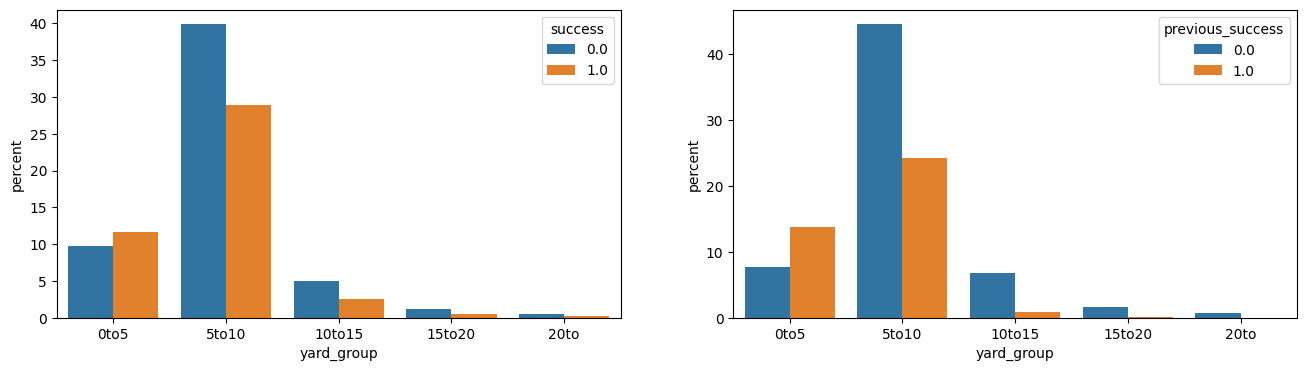

In [6]:
yard_bins = [0, 5, 10, 15, 20, np.inf]
yard_labels = ['0to5','5to10','10to15','15to20','20to']

df['yard_group'] = pd.cut(df['ydstosuccess_rounded'], bins=yard_bins, labels=yard_labels, right=False)

fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.countplot(data=df, x ='yard_group', hue='success', stat='percent', ax=axes[0])
sns.countplot(data=df, x ='yard_group', hue='previous_success', stat='percent', ax=axes[1])

plt.show()

<Axes: xlabel='offense_formation', ylabel='fp_epa'>

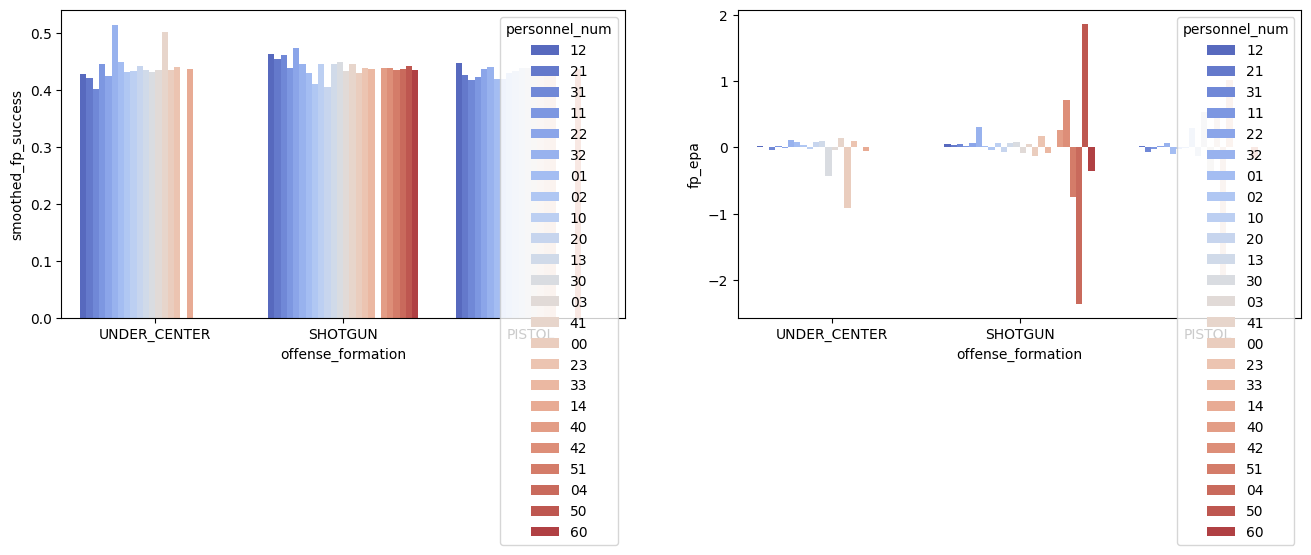

In [7]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.barplot(
    data=df,
    y='smoothed_fp_success',
    x='offense_formation',
    hue='personnel_num',
    ax=axes[0],
    palette='coolwarm'
)

sns.barplot(
    data=df,
    y='fp_epa',
    x='offense_formation',
    hue='personnel_num',
    ax=axes[1],
    palette='coolwarm'
)

In [8]:
df['yard_group']

0         5to10
1          0to5
2         5to10
3         5to10
4          0to5
          ...  
307571    5to10
307572    5to10
307573    5to10
307574    5to10
307575    5to10
Name: yard_group, Length: 307576, dtype: category
Categories (5, object): ['0to5' < '5to10' < '10to15' < '15to20' < '20to']

In [9]:
features = ['down','ydstosuccess','yard_group','yardline_100','offense_formation','personnel_num','extra_lineman_flag','score_differential','fp_success','fp_epa','success']
cat_features = ['yard_group','offense_formation','personnel_num']
target = 'success'

model = df[features]
model = pd.get_dummies(data=model, columns=cat_features)
model = model.copy()

Accuracy: 0.5851160673645881
              precision    recall  f1-score   support

         0.0       0.59      0.86      0.70     34651
         1.0       0.56      0.23      0.33     26865

    accuracy                           0.59     61516
   macro avg       0.58      0.55      0.51     61516
weighted avg       0.58      0.59      0.54     61516



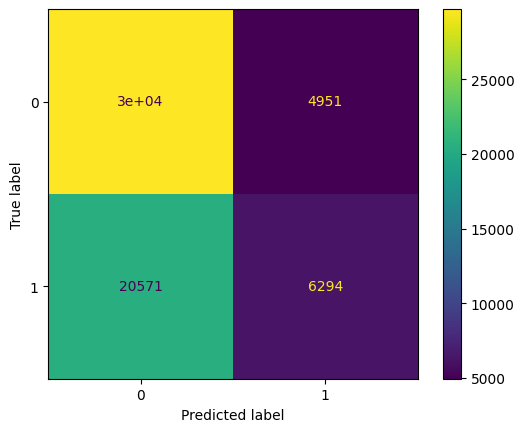

In [10]:
X_train, X_test, y_train, y_test = train_test_split(model.drop(columns='success'), model['success'], train_size=.8, random_state=42, stratify=model['success'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log = LogisticRegression(max_iter=1000, solver='lbfgs')
log.fit(X_train_scaled, y_train)

y_pred = log.predict(X_test_scaled)

ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [11]:
df['ep']

0         0.502278
1         0.838743
2         1.483283
3         0.937074
4         1.855370
            ...   
307571    2.129379
307572    1.283509
307573    0.920134
307574    0.008688
307575    2.711488
Name: ep, Length: 307576, dtype: float64

<Axes: xlabel='wp', ylabel='epa'>

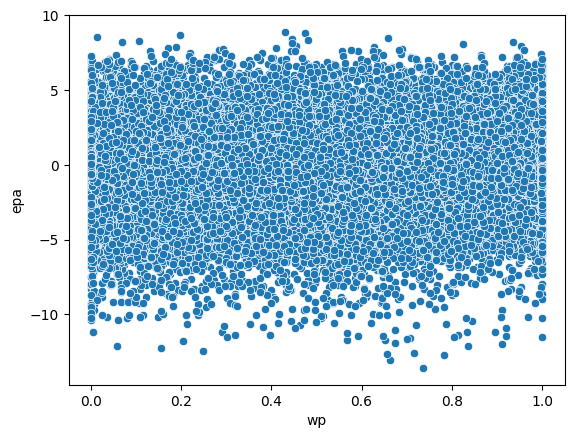

In [12]:
sns.scatterplot(df, x='wp',y='epa')

In [13]:
first = df[df['down'] == 1]
second = df[df['down'] == 2]
third = df[df['down'] == 3]
fourth = df[df['down'] == 4]

<Axes: xlabel='offense_formation', ylabel='count'>

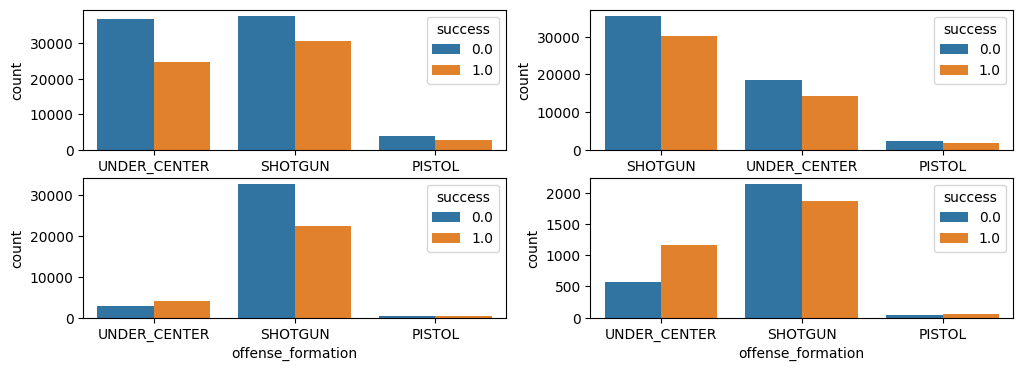

In [14]:
fig, axes = plt.subplots(2,2,figsize=(12,4))

sns.countplot(
    data=first,
    x = 'offense_formation',
    hue='success',
    ax = axes[0,0]
)

sns.countplot(
    data=second,
    x = 'offense_formation',
    hue='success',
    ax = axes[0,1]
)

sns.countplot(
    data=third,
    x = 'offense_formation',
    hue='success',
    ax = axes[1,0]
)

sns.countplot(
    data=fourth,
    x = 'offense_formation',
    hue='success',
    ax = axes[1,1]
)

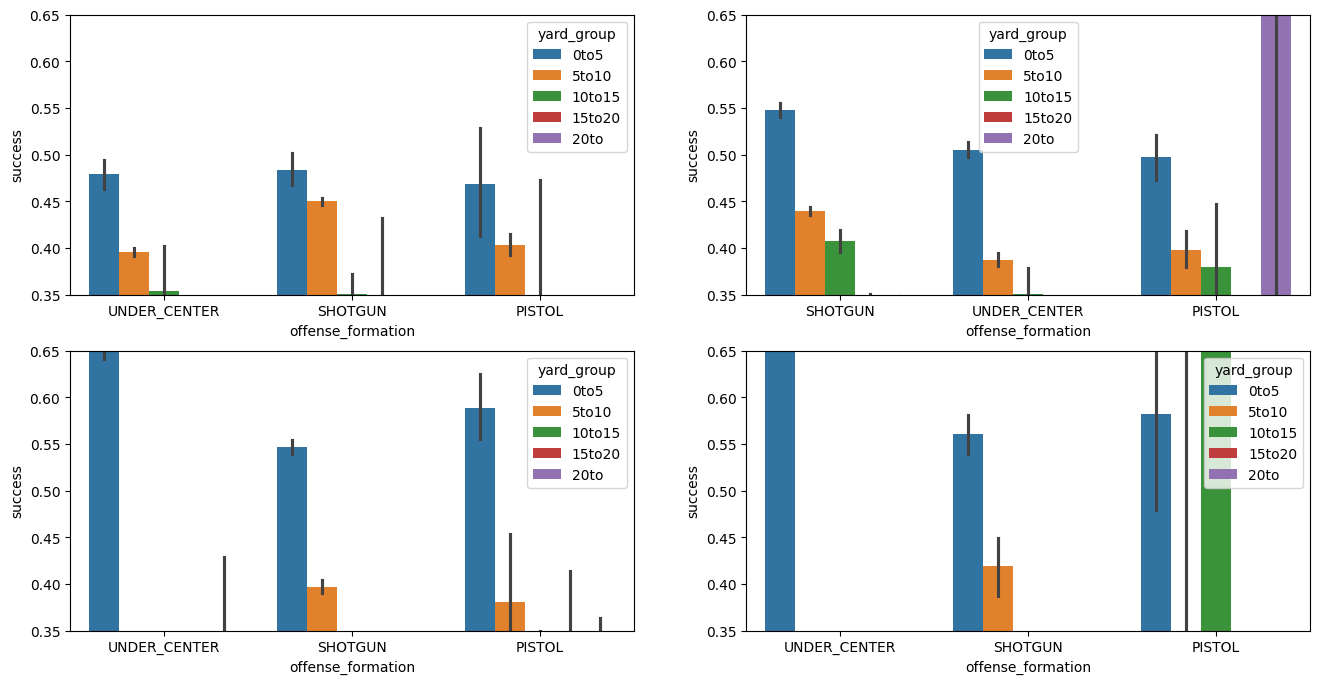

In [15]:
fig, axes = plt.subplots(2,2,figsize=(16,8))

sns.barplot(
    data=first,
    y='success',
    x='offense_formation',
    hue='yard_group',
    ax = axes[0,0]
)

sns.barplot(
    data=second,
    y='success',
    x='offense_formation',
    hue='yard_group',
    ax = axes[0,1]
)

sns.barplot(
    data=third,
    y='success',
    x='offense_formation',
    hue='yard_group',
    ax = axes[1,0]
)

sns.barplot(
    data=fourth,
    y='success',
    x='offense_formation',
    hue='yard_group',
    ax = axes[1,1]
)

for ax in axes.flat:
    ax.set_ylim(.35, .65)

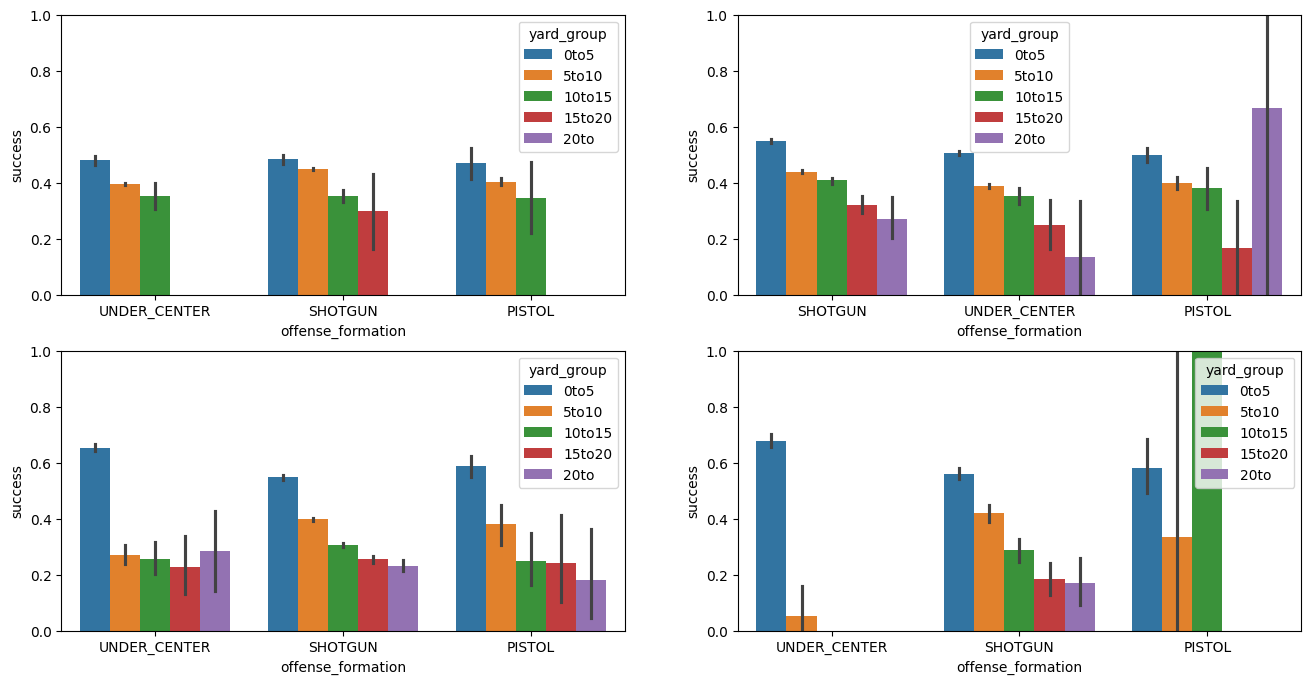

In [16]:
fig, axes = plt.subplots(2,2,figsize=(16,8))

sns.barplot(
    data=first,
    y='success',
    x='offense_formation',
    hue='yard_group',
    ax = axes[0,0]
)

sns.barplot(
    data=second,
    y='success',
    x='offense_formation',
    hue='yard_group',
    ax = axes[0,1]
)

sns.barplot(
    data=third,
    y='success',
    x='offense_formation',
    hue='yard_group',
    ax = axes[1,0]
)

sns.barplot(
    data=fourth,
    y='success',
    x='offense_formation',
    hue='yard_group',
    ax = axes[1,1]
)

for ax in axes.flat:
    ax.set_ylim(0, 1)

In [17]:
features = ['down','ydstosuccess','yard_group','yardline_100','offense_formation','personnel_num','extra_lineman_flag','score_differential','fp_success','fp_epa','success']
cat_features = ['yard_group','offense_formation','personnel_num']
target = 'success'

model_df = df[features]
model_df = pd.get_dummies(data=model_df, columns=cat_features)
model_df = model_df.copy()

X_train, X_test, y_train, y_test = train_test_split(model_df.drop(columns=target), model_df['success'], train_size=.8, random_state=42, stratify=model_df['success'])

In [18]:
def log_across_downs(X_train, X_test, y_train, y_test, down, threshold=.5):
    train_idx = X_train['down'] == down
    X_train = X_train[train_idx]
    y_train = y_train[train_idx]

    test_idx = X_test['down'] == down
    X_test = X_test[test_idx]
    y_test = y_test[test_idx]

    temp_model = LogisticRegression(max_iter=1000, verbose=100)

    temp_model.fit(X_train, y_train)
    y_pred = temp_model.predict(X_test)
    y_pred_probs = temp_model.predict_proba(X_test)[:, 1]
    y_pred_adj = (y_pred_probs > threshold).astype(int)

    class_report = classification_report(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)

    class_report_adj = classification_report(y_test, y_pred_adj)
    conf_adj = confusion_matrix(y_test, y_pred_adj)

    return [temp_model, train_idx, test_idx, y_pred, y_pred_probs, y_pred_adj, class_report, conf, class_report_adj, conf_adj]

In [ ]:
first = log_across_downs(X_train, X_test, y_train, y_test, 1)
second = log_across_downs(X_train, X_test, y_train, y_test, 2)
third = log_across_downs(X_train, X_test, y_train, y_test, 3)
fourth = log_across_downs(X_train, X_test, y_train, y_test, 4)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   31.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.1s finished


In [ ]:
print(first[5])
print(second[5])
print(third[5])
print(fourth[5])

              precision    recall  f1-score   support

         0.0       0.58      0.99      0.73     15761
         1.0       0.53      0.02      0.03     11630

    accuracy                           0.58     27391
   macro avg       0.55      0.50      0.38     27391
weighted avg       0.56      0.58      0.43     27391

              precision    recall  f1-score   support

         0.0       0.58      0.80      0.67     11229
         1.0       0.54      0.29      0.38      9257

    accuracy                           0.57     20486
   macro avg       0.56      0.55      0.53     20486
weighted avg       0.56      0.57      0.54     20486

              precision    recall  f1-score   support

         0.0       0.65      0.73      0.69      7120
         1.0       0.57      0.49      0.53      5368

    accuracy                           0.62     12488
   macro avg       0.61      0.61      0.61     12488
weighted avg       0.62      0.62      0.62     12488

              preci

,down,ydstosuccess,yardline_100,extra_lineman_flag,score_differential,fp_success,fp_epa,success,yard_group_0to4,yard_group_4to8,...,personnel_num_30,personnel_num_31,personnel_num_32,personnel_num_33,personnel_num_40,personnel_num_41,personnel_num_42,personnel_num_50,personnel_num_51,personnel_num_60
0,1.0,5.0,86.0,0,0.0,0.426230,0.019530,1.0,False,True,...,False,False,False,False,False,False,False,False,False,False
1,2.0,2.8,80.0,0,0.0,0.464400,0.057628,1.0,True,False,...,False,False,False,False,False,False,False,False,False,False
2,1.0,5.0,75.0,0,0.0,0.464400,0.057628,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
3,2.0,7.0,75.0,0,0.0,0.426230,0.019530,1.0,False,True,...,False,False,False,False,False,False,False,False,False,False
4,3.0,1.0,66.0,0,0.0,0.420136,0.006901,0.0,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307571,1.0,5.0,54.0,0,26.0,0.453555,0.039927,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
307572,2.0,4.2,50.0,0,26.0,0.453555,0.039927,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
307573,3.0,5.0,49.0,0,26.0,0.453555,0.039927,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
307574,4.0,6.0,50.0,0,26.0,0.438512,0.016268,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense,home_team,...,ydstosuccess,previous_success,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa,ydstosuccess_rounded,yard_group
0,2016_01_BUF_BAL,58,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,5.0,0.0,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,5,5to10
1,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,2.8,1.0,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173,3,0to5
2,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,5.0,1.0,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173,5,5to10
3,2016_01_BUF_BAL,130,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,7.0,0.0,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,7,5to10
4,2016_01_BUF_BAL,154,BAL,UNDER_CENTER,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,1.0,1.0,0.420136,0.420369,0.006901,0.429168,0.429205,0.010042,1,0to5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307571,2024_22_KC_PHI,4016,PHI,SHOTGUN,"2 G, 1 QB, 1 RB, 3 T, 2 TE, 2 WR",7.0,"2 CB, 2 DE, 1 DT, 1 FS, 2 ILB, 1 NT, 1 OLB, 1 SS",11,11,PHI,...,5.0,0.0,0.453555,0.453214,0.039927,0.441437,0.441424,0.021173,5,5to10
307572,2024_22_KC_PHI,4038,PHI,SHOTGUN,"2 G, 1 QB, 1 RB, 3 T, 2 TE, 2 WR",7.0,"2 CB, 2 DE, 1 DT, 1 FS, 2 ILB, 1 NT, 1 OLB, 1 SS",11,11,PHI,...,4.2,0.0,0.453555,0.453214,0.039927,0.441437,0.441424,0.021173,5,5to10
307573,2024_22_KC_PHI,4071,PHI,SHOTGUN,"2 G, 1 QB, 1 RB, 3 T, 2 TE, 2 WR",7.0,"2 CB, 2 DE, 1 DT, 1 FS, 2 ILB, 1 NT, 1 OLB, 1 SS",11,11,PHI,...,5.0,0.0,0.453555,0.453214,0.039927,0.441437,0.441424,0.021173,5,5to10
307574,2024_22_KC_PHI,4093,PHI,SHOTGUN,"2 G, 1 QB, 1 RB, 3 T, 1 TE, 3 WR",6.0,"2 CB, 2 DE, 1 DT, 2 FS, 2 ILB, 1 NT, 1 SS",11,11,PHI,...,6.0,0.0,0.438512,0.438506,0.016268,0.441437,0.441424,0.021173,6,5to10


In [ ]:
features2 = ['down','ydstosuccess','yard_group','offense_formation','score_differential','success']
cat_features2 = ['yard_group','offense_formation']
target = 'success'

model2_df = df[features2]
model2_df = pd.get_dummies(data=model2_df, columns=cat_features2)
model2_df = model_df.copy()

X_train, X_test, y_train, y_test = train_test_split(model2_df.drop(columns=target), model2_df['success'], train_size=.8, random_state=42, stratify=model2_df['success'])

In [ ]:
first2 = log_across_downs(X_train, X_test, y_train, y_test, 1)
second2 = log_across_downs(X_train, X_test, y_train, y_test, 2)
third2 = log_across_downs(X_train, X_test, y_train, y_test, 3)
fourth2 = log_across_downs(X_train, X_test, y_train, y_test, 4)

In [ ]:
print(first2[5])
print(second2[5])
print(third2[5])
print(fourth2[5])

              precision    recall  f1-score   support

         0.0       0.58      0.99      0.73     15761
         1.0       0.53      0.02      0.03     11630

    accuracy                           0.58     27391
   macro avg       0.55      0.50      0.38     27391
weighted avg       0.56      0.58      0.43     27391

              precision    recall  f1-score   support

         0.0       0.58      0.80      0.67     11229
         1.0       0.54      0.29      0.38      9257

    accuracy                           0.57     20486
   macro avg       0.56      0.55      0.53     20486
weighted avg       0.56      0.57      0.54     20486

              precision    recall  f1-score   support

         0.0       0.65      0.73      0.69      7120
         1.0       0.57      0.49      0.53      5368

    accuracy                           0.62     12488
   macro avg       0.61      0.61      0.61     12488
weighted avg       0.62      0.62      0.62     12488

              preci

In [ ]:
first = [log_across_downs(X_train, X_test, y_train, y_test, 1, i) for i in [.4,.42,.44,.46,.48,.50,.52,.54,.56,.58,.60]]
second = [log_across_downs(X_train, X_test, y_train, y_test, 2, i) for i in [.4,.42,.44,.46,.48,.50,.52,.54,.56,.58,.60]]
third = [log_across_downs(X_train, X_test, y_train, y_test, 3, i) for i in [.4,.42,.44,.46,.48,.50,.52,.54,.56,.58,.60]]
fourth = [log_across_downs(X_train, X_test, y_train, y_test, 4, i) for i in [.4,.42,.44,.46,.48,.50,.52,.54,.56,.58,.60]]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   26.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.2s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   26.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   25.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   25.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   24.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   25.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   28.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   28.2s
[Parallel(n_jobs=1)]: 

In [ ]:
first_matrices = [x[6] for x in first]
second_matrices = [x[6] for x in second]
third_matrices = [x[6] for x in third]
fourth_matrices = [x[6] for x in fourth]

In [ ]:
first_matrices_adj = [x[8] for x in first]
second_matrices_adj = [x[8] for x in second]
third_matrices_adj = [x[8] for x in third]
fourth_matrices_adj = [x[8] for x in fourth]

In [ ]:
for i in first_matrices_adj:
    print(i)

              precision    recall  f1-score   support

         0.0       0.63      0.26      0.37     15761
         1.0       0.44      0.79      0.57     11630

    accuracy                           0.48     27391
   macro avg       0.53      0.52      0.47     27391
weighted avg       0.55      0.48      0.45     27391

              precision    recall  f1-score   support

         0.0       0.61      0.44      0.51     15761
         1.0       0.45      0.61      0.52     11630

    accuracy                           0.51     27391
   macro avg       0.53      0.53      0.51     27391
weighted avg       0.54      0.51      0.51     27391

              precision    recall  f1-score   support

         0.0       0.60      0.59      0.59     15761
         1.0       0.45      0.46      0.46     11630

    accuracy                           0.54     27391
   macro avg       0.53      0.53      0.53     27391
weighted avg       0.54      0.54      0.54     27391

              preci

In [ ]:
for i in second_matrices_adj:
    print(i)

              precision    recall  f1-score   support

         0.0       0.64      0.26      0.37     11229
         1.0       0.48      0.82      0.60      9257

    accuracy                           0.51     20486
   macro avg       0.56      0.54      0.49     20486
weighted avg       0.57      0.51      0.47     20486

              precision    recall  f1-score   support

         0.0       0.62      0.40      0.48     11229
         1.0       0.49      0.70      0.58      9257

    accuracy                           0.53     20486
   macro avg       0.55      0.55      0.53     20486
weighted avg       0.56      0.53      0.52     20486

              precision    recall  f1-score   support

         0.0       0.61      0.55      0.58     11229
         1.0       0.51      0.57      0.54      9257

    accuracy                           0.56     20486
   macro avg       0.56      0.56      0.56     20486
weighted avg       0.56      0.56      0.56     20486

              preci

In [ ]:
for i in third_matrices_adj:
    print(i)

              precision    recall  f1-score   support

         0.0       0.68      0.55      0.61      7120
         1.0       0.53      0.66      0.58      5368

    accuracy                           0.60     12488
   macro avg       0.60      0.61      0.60     12488
weighted avg       0.61      0.60      0.60     12488

              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64      7120
         1.0       0.54      0.59      0.56      5368

    accuracy                           0.61     12488
   macro avg       0.60      0.61      0.60     12488
weighted avg       0.61      0.61      0.61     12488

              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67      7120
         1.0       0.56      0.54      0.55      5368

    accuracy                           0.62     12488
   macro avg       0.61      0.61      0.61     12488
weighted avg       0.62      0.62      0.62     12488

              preci

ClassifcationReport:               precision    recall  f1-score   support

         0.0       0.63      0.26      0.37     15761
         1.0       0.44      0.79      0.57     11630

    accuracy                           0.48     27391
   macro avg       0.53      0.52      0.47     27391
weighted avg       0.55      0.48      0.45     27391

ClassifcationReport:               precision    recall  f1-score   support

         0.0       0.61      0.44      0.51     15761
         1.0       0.45      0.61      0.52     11630

    accuracy                           0.51     27391
   macro avg       0.53      0.53      0.51     27391
weighted avg       0.54      0.51      0.51     27391

ClassifcationReport:               precision    recall  f1-score   support

         0.0       0.60      0.59      0.59     15761
         1.0       0.45      0.46      0.46     11630

    accuracy                           0.54     27391
   macro avg       0.53      0.53      0.53     27391
weighted av

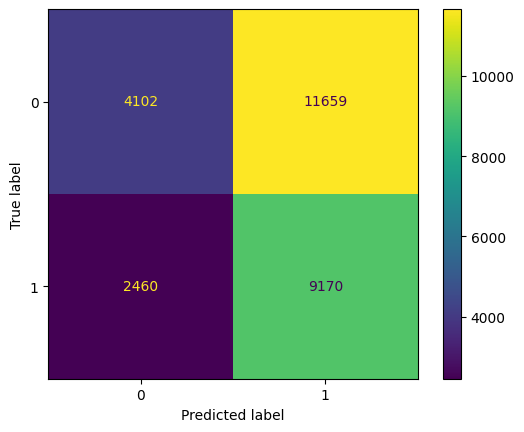

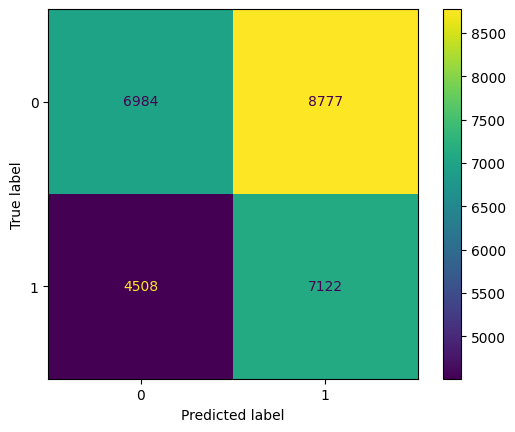

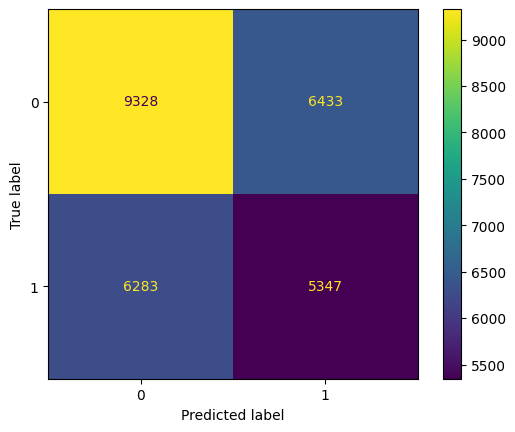

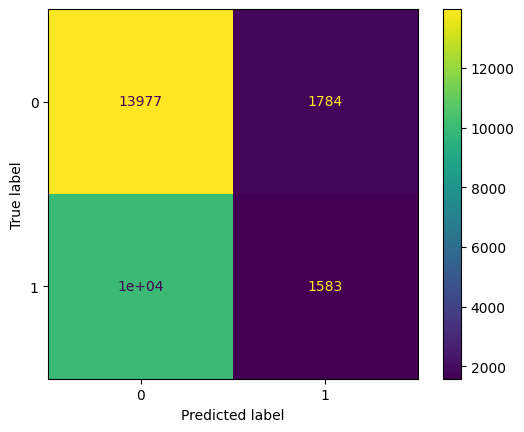

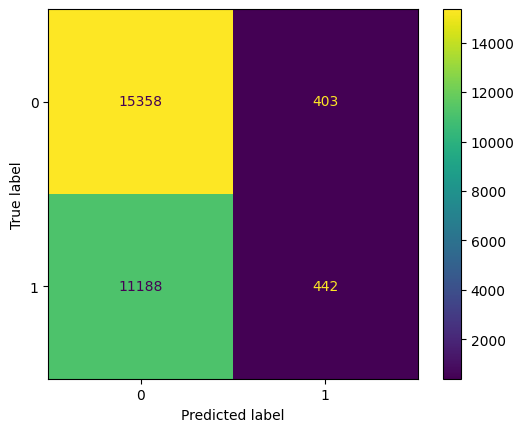

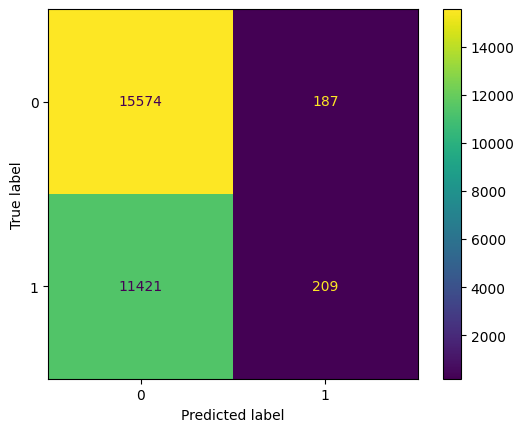

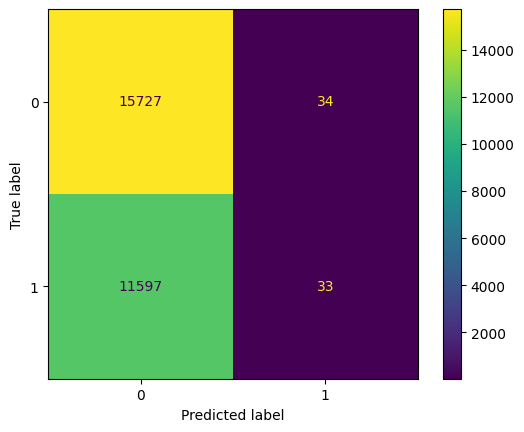

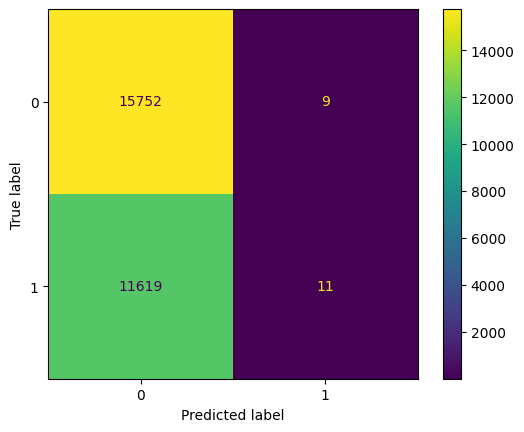

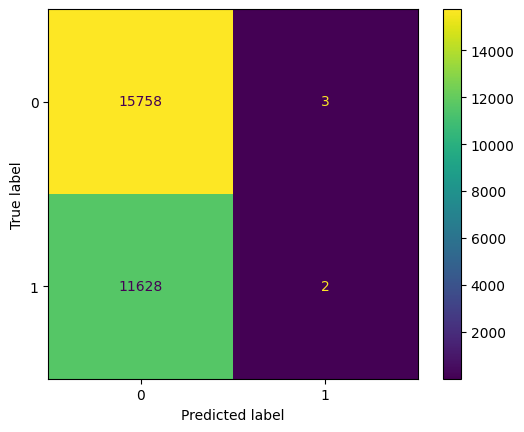

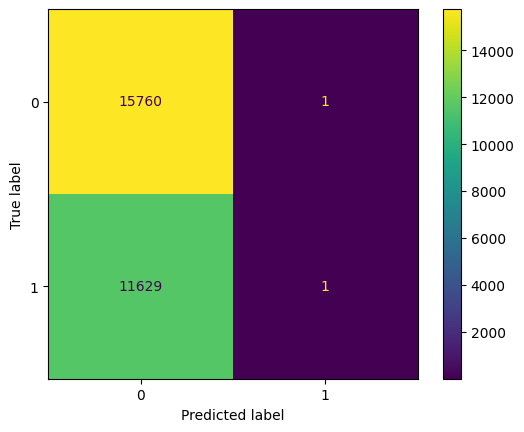

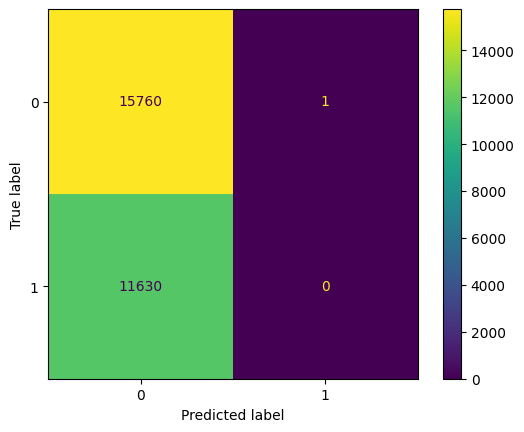

In [ ]:
for i in first:
    class_adj = i[8]
    conf_adj = i[9]
    print(f'ClassifcationReport: {class_adj}')
    ConfusionMatrixDisplay(conf_adj).plot()

In [ ]:
features3 = ['down','yard_group','offense_formation','success']
cat_features3 = ['yard_group','offense_formation']
target = 'success'

model3_df = df[features3]
model3_df = pd.get_dummies(data=model3_df, columns=cat_features3)
model3_df = model_df.copy()

X_train, X_test, y_train, y_test = train_test_split(model3_df.drop(columns=target), model3_df['success'], train_size=.8, random_state=42, stratify=model3_df['success'])

In [ ]:
first3 = [log_across_downs(X_train, X_test, y_train, y_test, 1, i) for i in [.4,.42,.44,.46,.48,.50]]
second3 = [log_across_downs(X_train, X_test, y_train, y_test, 2, i) for i in [.4,.42,.44,.46,.48,.50]]
third3 = [log_across_downs(X_train, X_test, y_train, y_test, 3, i) for i in [.4,.42,.44,.46,.48,.50]]
fourth3 = [log_across_downs(X_train, X_test, y_train, y_test, 4, i) for i in [.4,.42,.44,.46,.48,.50]]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   27.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.0s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.3s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   25.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   25.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   26.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.4s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   24.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   20.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   21.2s
[Parallel(n_jobs=1)]: 

ClassifcationReport:
              precision    recall  f1-score   support

         0.0       0.72      0.33      0.45       541
         1.0       0.60      0.89      0.71       610

    accuracy                           0.62      1151
   macro avg       0.66      0.61      0.58      1151
weighted avg       0.66      0.62      0.59      1151

ClassifcationReport:
              precision    recall  f1-score   support

         0.0       0.71      0.34      0.46       541
         1.0       0.60      0.87      0.71       610

    accuracy                           0.62      1151
   macro avg       0.65      0.61      0.59      1151
weighted avg       0.65      0.62      0.59      1151

ClassifcationReport:
              precision    recall  f1-score   support

         0.0       0.68      0.37      0.48       541
         1.0       0.60      0.85      0.70       610

    accuracy                           0.62      1151
   macro avg       0.64      0.61      0.59      1151
weighted av

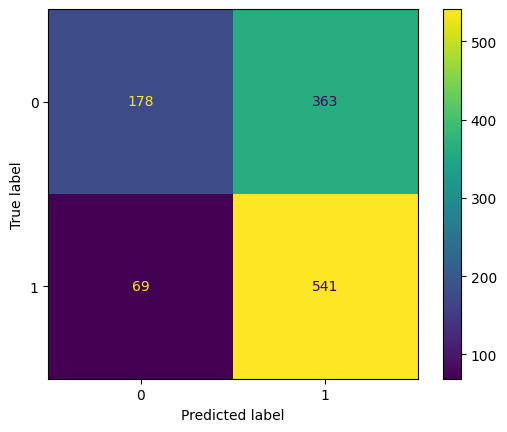

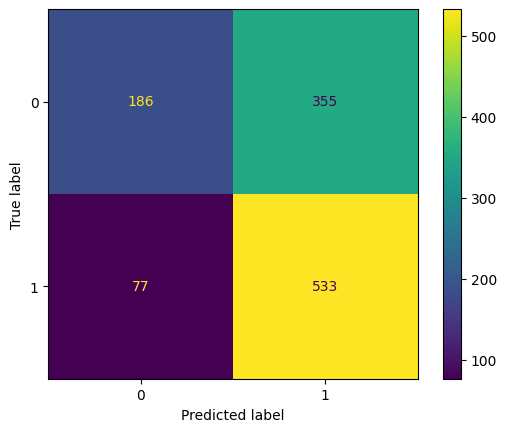

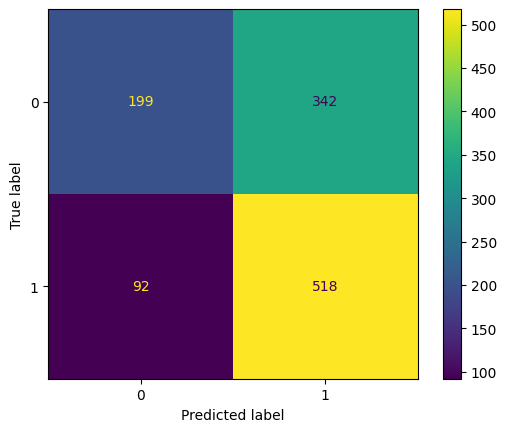

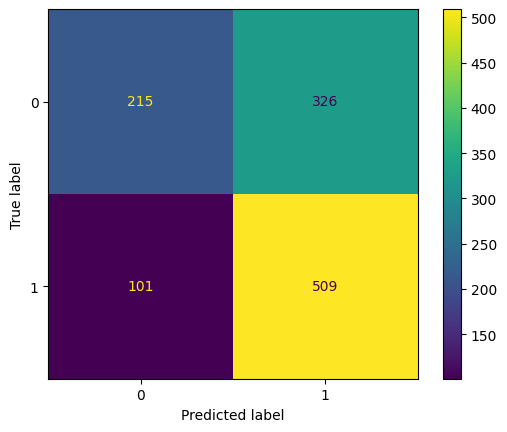

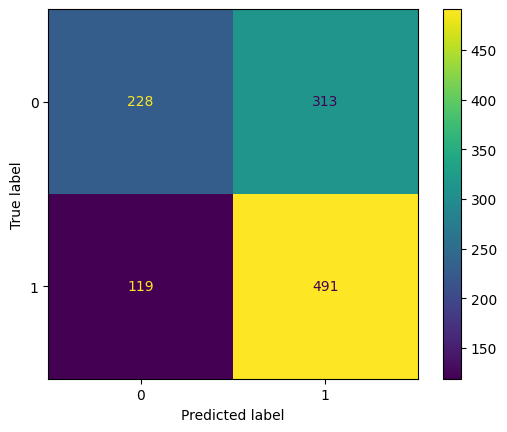

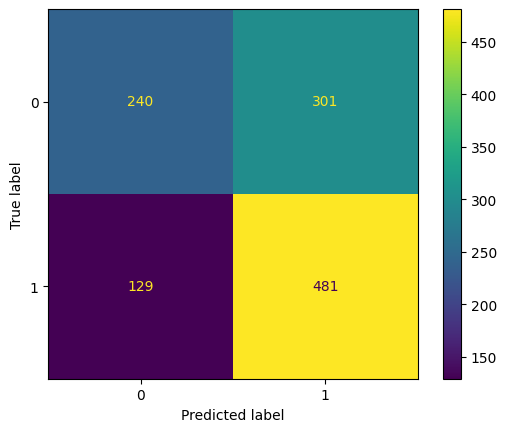

In [ ]:
for i in fourth3:
    class_adj = i[8]
    conf_adj = i[9]
    print(f'ClassifcationReport:\n{class_adj}')
    ConfusionMatrixDisplay(conf_adj).plot()

In [ ]:
# Choose threshold
# first3 -> .42
# second3 -> .44
# third3 -> .42
# fourth3 -> .46

y_test[first3[1][2]]['y_guess'] = first3[1][5]
y_test[second3[1][2]]['y_guess'] = second3[1][5]
y_test[third3[1][2]]['y_guess'] = third3[1][5]
y_test[fourth3[1][2]]['y_guess'] = fourth3[1][5]
y_test

48946     0.0
271459    1.0
57470     1.0
280678    0.0
188796    1.0
         ... 
160813    1.0
230043    1.0
81077     0.0
89626     0.0
110523    1.0
Name: success, Length: 61516, dtype: float64

In [ ]:
y_test[second3[1][2]]['y_guess'] = second3[1][5]
y_test


48946     0.0
271459    1.0
57470     1.0
280678    0.0
188796    1.0
         ... 
160813    1.0
230043    1.0
81077     0.0
89626     0.0
110523    1.0
Name: success, Length: 61516, dtype: float64

In [ ]:
model_1 = first3[1][0]
model_2 = second3[2][0]
model_3 = third3[3][0]
model_4 = fourth3[3][0]

models = {
    1: model_1,  # your fitted logistic model for 1st down
    2: model_2,
    3: model_3,
    4: model_4
}

# And determined the best thresholds per down from your sweeps
thresholds = {
    1: 0.42,
    2: 0.44,
    3: 0.46,
    4: 0.46
}

# Combine everything into one prediction function
def predict_combined(X, models, thresholds):
    y_pred = np.zeros(len(X))
    y_proba = np.zeros(len(X))

    for down in models.keys():
        idx = X['down'] == down
        if idx.sum() == 0:
            continue
        model = models[down]
        threshold = thresholds[down]
        
        # Predict probabilities for class 1 (success)
        probs = model.predict_proba(X.loc[idx])[:, 1]
        preds = (probs > threshold).astype(int)
        
        y_pred[idx] = preds
        y_proba[idx] = probs

    return y_pred, y_proba

# Example usage
y_pred, y_proba = predict_combined(X_test, models, thresholds)

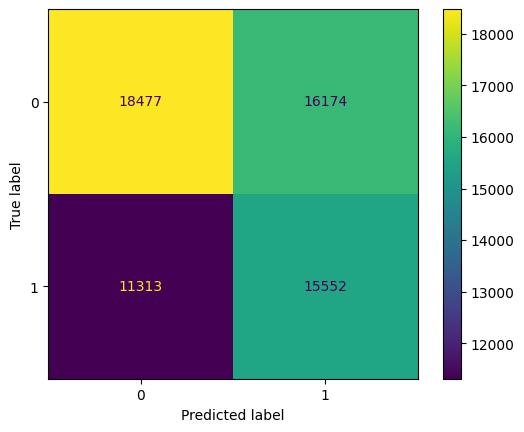

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.53      0.57     34651
         1.0       0.49      0.58      0.53     26865

    accuracy                           0.55     61516
   macro avg       0.56      0.56      0.55     61516
weighted avg       0.56      0.55      0.55     61516



In [ ]:
meta_X = pd.DataFrame({
    'down': X_test['down'],
    'prob_down1': model_1.predict_proba(X_test[first3[1][2]])[:,1],
    'prob_down2': model_2.predict_proba(X_test[second3[2][2]])[:,1],
    'prob_down3': model_3.predict_proba(X_test[third3[3][2]])[:,1],
    'prob_down4': model_4.predict_proba(X_test[fourth3[3][2]])[:,1],
})
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_X, y_test)

ValueError: All arrays must be of the same length

In [ ]:
meta_X = pd.DataFrame({'down': X_test['down']})

# Initialize empty probability columns
meta_X['prob_down1'] = 0.0
meta_X['prob_down2'] = 0.0
meta_X['prob_down3'] = 0.0
meta_X['prob_down4'] = 0.0

# Fill probabilities only where the 'down' matches
for d, model in zip([1, 2, 3, 4], [model_1, model_2, model_3, model_4]):
    idx = X_test['down'] == d
    meta_X.loc[idx, f'prob_down{d}'] = model.predict_proba(X_test.loc[idx])[:, 1]

In [ ]:
meta_X

,down,prob_down1,prob_down2,prob_down3,prob_down4
48946,2.0,0.000000,0.379790,0.000000,0.0
271459,2.0,0.000000,0.429357,0.000000,0.0
57470,2.0,0.000000,0.506742,0.000000,0.0
280678,1.0,0.460732,0.000000,0.000000,0.0
188796,1.0,0.453465,0.000000,0.000000,0.0
...,...,...,...,...,...
160813,1.0,0.546661,0.000000,0.000000,0.0
230043,1.0,0.424462,0.000000,0.000000,0.0
81077,2.0,0.000000,0.392416,0.000000,0.0
89626,3.0,0.000000,0.000000,0.240453,0.0


In [ ]:
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_X, y_test)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
meta_pred = meta_model.predict(meta_X)
meta_proba = meta_model.predict_proba(meta_X)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, meta_pred))
print("Meta AUC:", roc_auc_score(y_test, meta_proba))

              precision    recall  f1-score   support

         0.0       0.59      0.87      0.70     34651
         1.0       0.56      0.22      0.31     26865

    accuracy                           0.58     61516
   macro avg       0.58      0.54      0.51     61516
weighted avg       0.58      0.58      0.53     61516

Meta AUC: 0.5847356552702276


In [ ]:
meta_X = pd.DataFrame({
    'down': X_test['down'],
    'prob': 0.0
})

for d, model in zip([1,2,3,4], [model_1, model_2, model_3, model_4]):
    idx = X_test['down'] == d
    meta_X.loc[idx, 'prob'] = model.predict_proba(X_test.loc[idx])[:,1]

In [ ]:
meta_X = pd.get_dummies(meta_X, columns=['down'], prefix='down')
meta_model.fit(meta_X, y_test)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
meta_pred = meta_model.predict(meta_X)
meta_proba = meta_model.predict_proba(meta_X)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, meta_pred))
print("Meta AUC:", roc_auc_score(y_test, meta_proba))

              precision    recall  f1-score   support

         0.0       0.59      0.86      0.70     34651
         1.0       0.56      0.23      0.32     26865

    accuracy                           0.58     61516
   macro avg       0.58      0.54      0.51     61516
weighted avg       0.58      0.58      0.54     61516

Meta AUC: 0.5847453297879652


In [ ]:

yard_bins = np.arange(0, bin_count * bin_size + bin_size, bin_size)
yard_labels = [f'{str(yard_bins[i])}to{str(yard_bins[i+1])}' for i in range(len(yard_bins)-1)]

NameError: name 'np' is not defined

In [ ]:
features3 = ['down','yard_group','offense_formation','success']
cat_features3 = ['down','yard_group','offense_formation']
target = 'success'

model3_df = df[features3]
model3_df = pd.get_dummies(data=model3_df, columns=cat_features3)
model3_df = model_df.copy()

X_train, X_test, y_train, y_test = train_test_split(model3_df.drop(columns=target), model3_df['success'], train_size=.8, random_state=42, stratify=model3_df['success'])

NameError: name 'df' is not defined